In [1]:
import pickle
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from PIL import Image

In [2]:
weights_path = '/common/home/as3503/as3503/courses/cs535/535/stylegan3/output_images/00010-stylegan3-r-stylegan3_zipped-gpus1-batch4-gamma8.2/network-snapshot-002200.pkl'
device = torch.device('cuda:7')

In [3]:
with open(weights_path, 'rb') as f:
    weights = pickle.load(f)

In [4]:
G = weights['G_ema'].to(device)

In [5]:
G.z_dim

512

In [6]:
z = torch.randn([1, G.z_dim]).to(device)

In [7]:
c = None

In [8]:
img = G(z, c)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


In [9]:
img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)

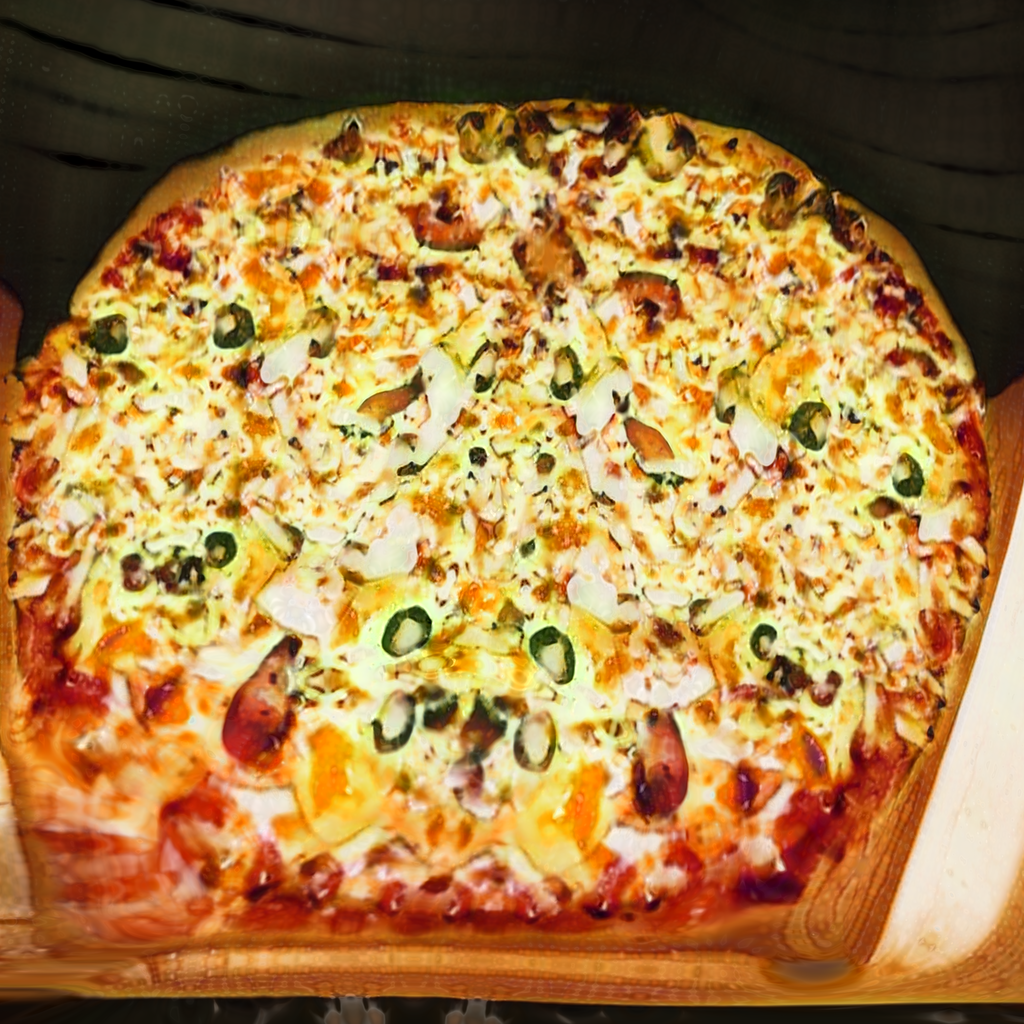

In [10]:
Image.fromarray(img[0].cpu().numpy(), 'RGB')

In [14]:
G.num_layers = 14

In [30]:
G.synthesis.L0_36_1024.weight.T.shape

torch.Size([1, 1, 1024, 1024])

In [21]:
G.synthesis.layer_names

['L0_36_1024',
 'L1_36_1024',
 'L2_52_1024',
 'L3_52_1024',
 'L4_84_1024',
 'L5_148_1024',
 'L6_148_1024',
 'L7_276_645',
 'L8_276_406',
 'L9_532_256',
 'L10_1044_161',
 'L11_1044_102',
 'L12_1044_64',
 'L13_1024_64',
 'L14_1024_3']

In [50]:
! pwd

/common/users/as3503/courses/cs535/535/stylegan3


In [48]:
from utils import parse_indices


def get_layer_weights(generator, gan_type, layers='0-6'):
    weights = []
    
    for i in range(7):
        if gan_type == 'stylegan3':
            weight = generator.synthesis.__getattr__(generator.synthesis.layer_names[i]).weight
        weights.append(weight.detach().squeeze().cpu().numpy())
        print(weight.shape)
        
    weights = np.concatenate(weights, axis=1).astype(np.float32)
    weights = weights / np.linalg.norm(weights, axis=0, keepdims=True)
    eigen_values, eigen_vectors = np.linalg.eig(weights.dot(weights.T))
    return layers, eigen_values, eigen_vectors

ImportError: attempted relative import with no known parent package

In [41]:
weights, eigen_values, eigen_vectors = get_layer_weights(G, 'stylegan3')

torch.Size([1024, 1024, 1, 1])
torch.Size([1024, 1024, 1, 1])
torch.Size([1024, 1024, 1, 1])
torch.Size([1024, 1024, 1, 1])
torch.Size([1024, 1024, 1, 1])
torch.Size([1024, 1024, 1, 1])
torch.Size([1024, 1024, 1, 1])


In [42]:
weights.shape

(1024, 7168)

In [44]:
eigen_values.shape

(1024,)

In [46]:
eigen_vectors.shape

(1024, 1024)

In [ ]:
#@title
import os.path
import io
import IPython.display
import numpy as np
import cv2
import PIL.Image

import torch

from models import parse_gan_type
from utils import to_tensor
from utils import postprocess
from utils import load_generator
from utils import factorize_weight


def load_generator_sg3(model_name):
    if model_name == 'stylegan3':
        weights_path = '/common/home/as3503/as3503/courses/cs535/535/stylegan3/output_images/00010-stylegan3-r-stylegan3_zipped-gpus1-batch4-gamma8.2/network-snapshot-002200.pkl'
    with open(weights_path, 'rb') as f:
        weights = pickle.load(f)
    G = weights['G_ema'].to(device)
    return G
        
    

def sample(generator, gan_type, num=1, seed=0):
  """Samples latent codes."""
  torch.manual_seed(seed)
  codes = torch.randn(num, generator.z_space_dim).cuda()
  if gan_type == 'pggan':
    codes = generator.layer0.pixel_norm(codes)
  elif gan_type == 'stylegan':
    codes = generator.mapping(codes)['w']
    codes = generator.truncation(codes, trunc_psi=0.7, trunc_layers=8)
  elif gan_type == 'stylegan2':
    codes = generator.mapping(codes)['w']
    codes = generator.truncation(codes, trunc_psi=0.5, trunc_layers=18)
  codes = codes.detach().cpu().numpy()
  return codes


def synthesize(generator, gan_type, codes):
  """Synthesizes images with the give codes."""
  if gan_type == 'pggan':
    images = generator(to_tensor(codes))['image']
  elif gan_type in ['stylegan', 'stylegan2']:
    images = generator.synthesis(to_tensor(codes))['image']
  images = postprocess(images)
  return images


def imshow(images, col, viz_size=256):
  """Shows images in one figure."""
  num, height, width, channels = images.shape
  assert num % col == 0
  row = num // col

  fused_image = np.zeros((viz_size * row, viz_size * col, channels), dtype=np.uint8)

  for idx, image in enumerate(images):
    i, j = divmod(idx, col)
    y = i * viz_size
    x = j * viz_size
    if height != viz_size or width != viz_size:
      image = cv2.resize(image, (viz_size, viz_size))
    fused_image[y:y + viz_size, x:x + viz_size] = image

  fused_image = np.asarray(fused_image, dtype=np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(fused_image).save(data, 'jpeg')
  im_data = data.getvalue()
  disp = IPython.display.display(IPython.display.Image(im_data))
  return disp